In [18]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters

with h5py.File('train.h5', 'r') as f:
    X = f['x'][:]
    Y = f['y'][:]

print(X.shape)
print(Y.shape)

# Convierte X a un DataFrame de pandas
df_X = pd.DataFrame(X.reshape(-1, X.shape[-1]))

# Convierte Y a un DataFrame de pandas
df_Y = pd.DataFrame(Y, columns=['Target'])

# Une los dos DataFrames
df = pd.concat([df_X, df_Y], axis=1)

print(df)

num_trials = 18530

df_tsfresh = pd.DataFrame({
    'id': np.repeat(df.index, num_trials),
    'time': np.tile(np.arange(num_trials), len(df)),
    'value': df.drop(columns='Target').values.flatten()
})
print(df_tsfresh)

#print quantity of zeros and ones
print(df_Y['Target'].value_counts())

(204, 1, 18530)
(204,)
            0         1         2  ...     18528     18529  Target
0   -0.005859 -0.011414 -0.010773  ... -0.021637 -0.018860       0
1    0.002380  0.005127  0.005737  ... -0.005981 -0.007660       1
2    0.058075  0.122040  0.108307  ... -0.014130 -0.018250       0
3   -0.007385 -0.011932 -0.004700  ... -0.030273 -0.039368       0
4   -0.000458 -0.001099  0.003723  ...  0.004242  0.003235       0
..        ...       ...       ...  ...       ...       ...     ...
199  0.008179  0.015106  0.013245  ...  0.025818  0.018951       0
200  0.007660  0.011230  0.004974  ...  0.023987  0.029541       0
201  0.015167  0.031799  0.026978  ... -0.000824  0.000305       0
202  0.002533  0.005219  0.003571  ... -0.003357 -0.003479       0
203 -0.002991 -0.004120  0.000366  ... -0.009552 -0.019318       1

[204 rows x 18531 columns]
          id   time     value
0          0      0 -0.005859
1          0      1 -0.011414
2          0      2 -0.010773
3          0      3 -0.01

In [5]:

features = extract_features(df_tsfresh, column_id='id', column_sort='time', n_jobs=24, default_fc_parameters=EfficientFCParameters())
print(features)

Feature Extraction: 100%|██████████| 102/102 [02:15<00:00,  1.33s/it]


     value__variance_larger_than_standard_deviation  ...  value__mean_n_absolute_max__number_of_maxima_7
0                                               0.0  ...                                        0.232910
1                                               0.0  ...                                        0.266963
2                                               0.0  ...                                        0.207986
3                                               0.0  ...                                        0.154306
4                                               0.0  ...                                        0.336108
..                                              ...  ...                                             ...
199                                             0.0  ...                                        0.096885
200                                             0.0  ...                                        0.368783
201                                             0.0  ..

              precision    recall  f1-score   support

           0       0.81      0.83      0.82        46
           1       0.47      0.44      0.45        16

    accuracy                           0.73        62
   macro avg       0.64      0.63      0.63        62
weighted avg       0.72      0.73      0.72        62

0.7258064516129032


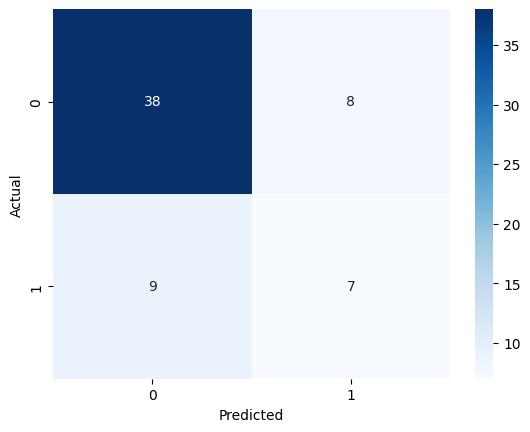

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Asume que 'features' es tu DataFrame con las características extraídas y 'df_Y' es tu DataFrame con las etiquetas
X = features
y = df_Y['Target']

# Divide tus datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

clf = DecisionTreeClassifier()

# Entrena el clasificador
clf.fit(X_train, y_train)

# Haz predicciones en el conjunto de prueba
y_pred = clf.predict(X_test)

# Imprime un informe de clasificación
print(classification_report(y_test, y_pred))

#get accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

#create confusion matrix
from sklearn.metrics import confusion_matrix

#plot confusion matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
